In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'
 
from __future__ import absolute_import, division, print_function
# http://www.lfd.uci.edu/~gohlke/pythonlibs/#xgboost各种python库文件的下载，基本可以找到所有的
import sys
import os
 
import pandas as pd
import numpy as np
 
# # Remote Data Access
# import pandas_datareader.data as web
# import datetime
# # reference: https://pandas-datareader.readthedocs.io/en/latest/remote_data.html
 
# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
 
# Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns
 
pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy
 
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
 
# seaborn plotting style
sns.set(style='ticks', context='poster')

In [2]:
filename_ts = 'data.csv'
ts_df = pd.read_csv(filename_ts, index_col=0, parse_dates=[0])
n_sample = ts_df.shape[0]

In [3]:
print(ts_df.shape)
print(ts_df.head())

(1763, 6)
                  open        high         low       close  volume   \
data                                                                  
2015-01-02 17823.07000 17951.78000 17731.30000 17832.99000        0   
2015-01-05 17821.30000 17821.30000 17475.93000 17501.65000        0   
2015-01-06 17504.18000 17581.05000 17262.37000 17371.64000        0   
2015-01-07 17374.78000 17597.08000 17374.78000 17584.52000        0   
2015-01-08 17591.97000 17916.04000 17591.97000 17907.87000        0   

           changepercent  
data                      
2015-01-02         0.06%  
2015-01-05        -1.86%  
2015-01-06        -0.74%  
2015-01-07         1.23%  
2015-01-08         1.84%  


In [4]:
n_train=int(0.95*n_sample)+1
n_forecast=n_sample-n_train
#ts_df
ts_train = ts_df.iloc[:n_train]['close']
ts_test = ts_df.iloc[n_train:]['close']
print(ts_train.shape)
print(ts_test.shape)
print("Training Series:", "\n", ts_train.tail(), "\n")
print("Testing Series:", "\n", ts_test.head())

(1675,)
(88,)
Training Series: 
 data
2021-08-20   35120.08000
2021-08-23   35335.71000
2021-08-24   35366.26000
2021-08-25   35405.50000
2021-08-26   35213.12000
Name: close, dtype: float64 

Testing Series: 
 data
2021-08-27   35455.80000
2021-08-30   35399.84000
2021-08-31   35360.73000
2021-09-01   35312.53000
2021-09-02   35443.82000
Name: close, dtype: float64


In [5]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
     
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
     
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

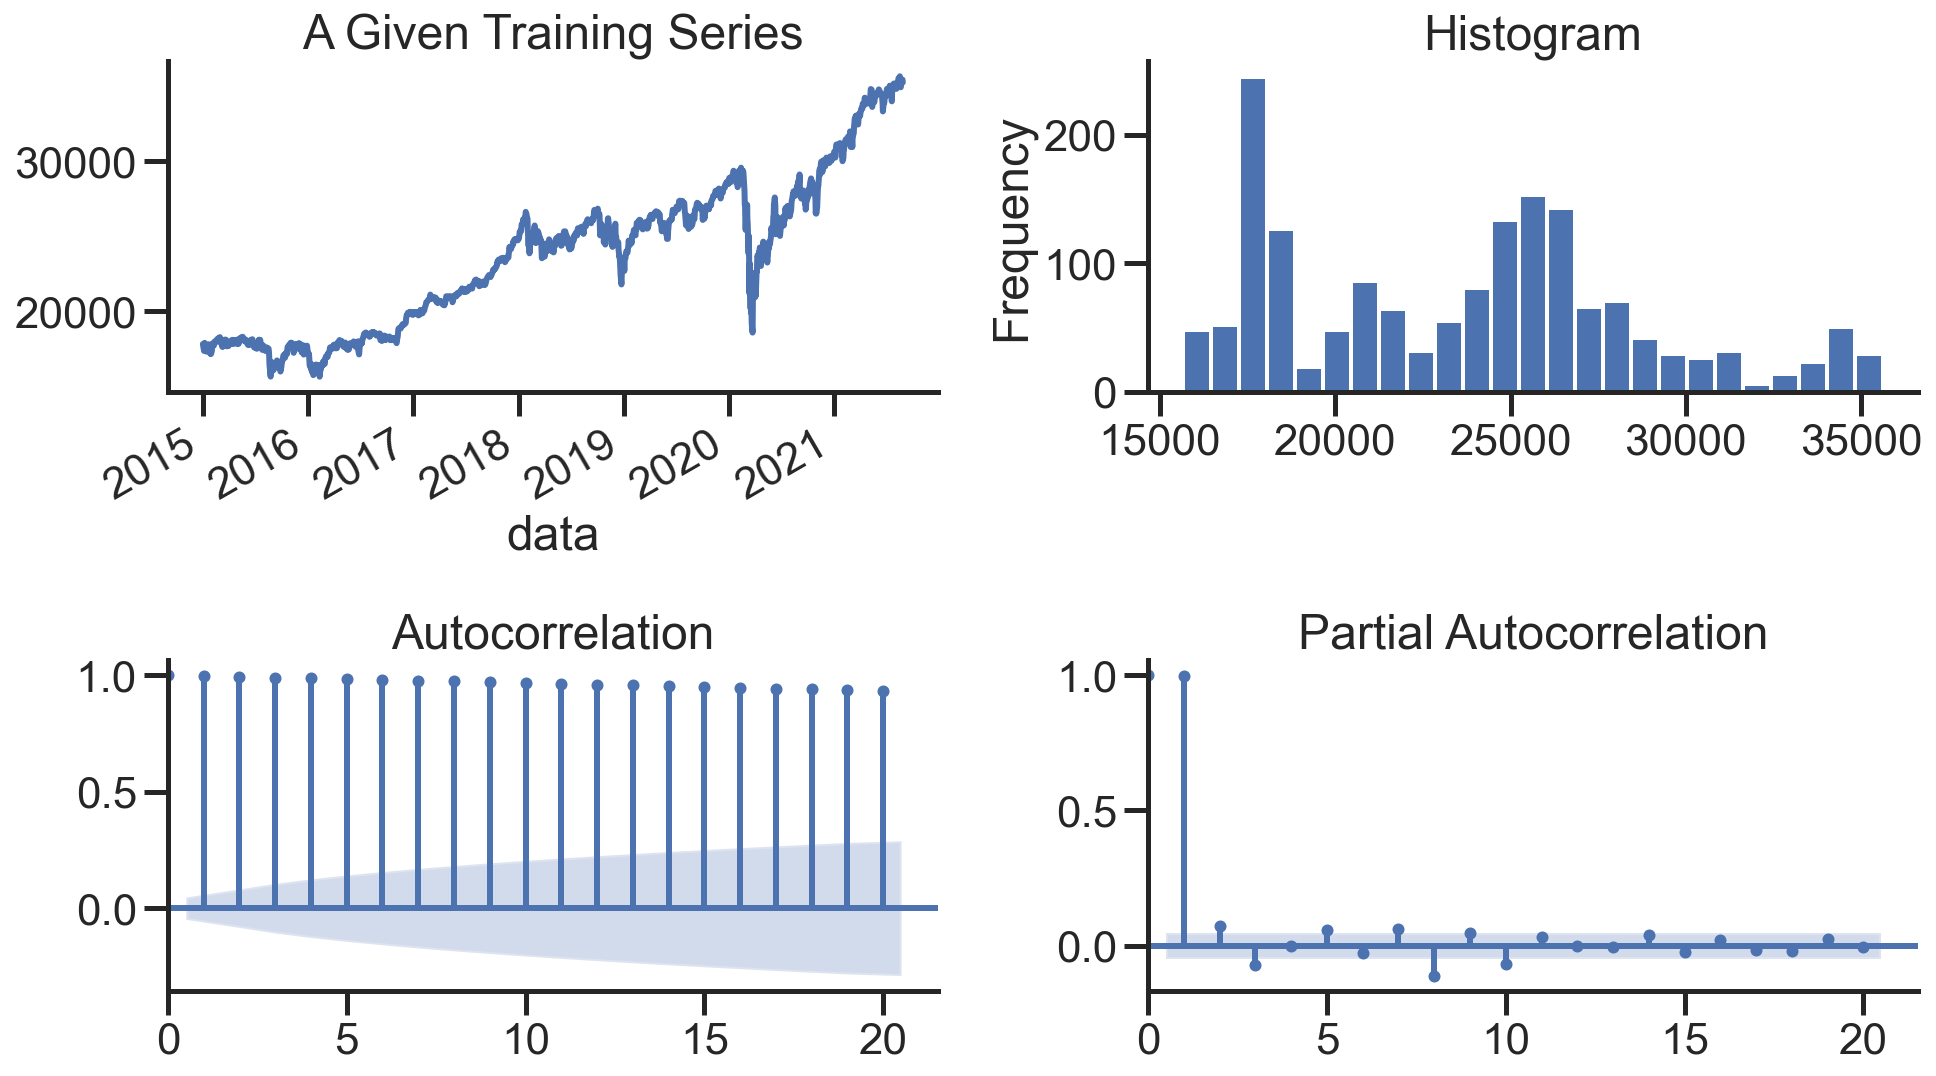

In [6]:
tsplot(ts_train, title='A Given Training Series', lags=20);

In [7]:
#Model Estimation
 
# Fit the model
arima200 = sm.tsa.SARIMAX(ts_train, order=(1,0,0))#order里边的三个参数p,d,q
model_results = arima200.fit()#fit模型

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [8]:
import itertools
#当多组值都不符合时，遍历多组值，得出最好的值
p_min = 0
d_min = 0
q_min = 0
p_max = 2
d_max = 0
q_max = 10
 
# Initialize a DataFrame to store the results
results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])
 
for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue
     
    try:
        model = sm.tsa.SARIMAX(ts_train, order=(p, d, q),
                               #enforce_stationarity=False,
                               #enforce_invertibility=False,
                              )
        results = model.fit()
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float)

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored

D:\Anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda\lib\site-packages\st

D:\Anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda\lib\site-packages\st

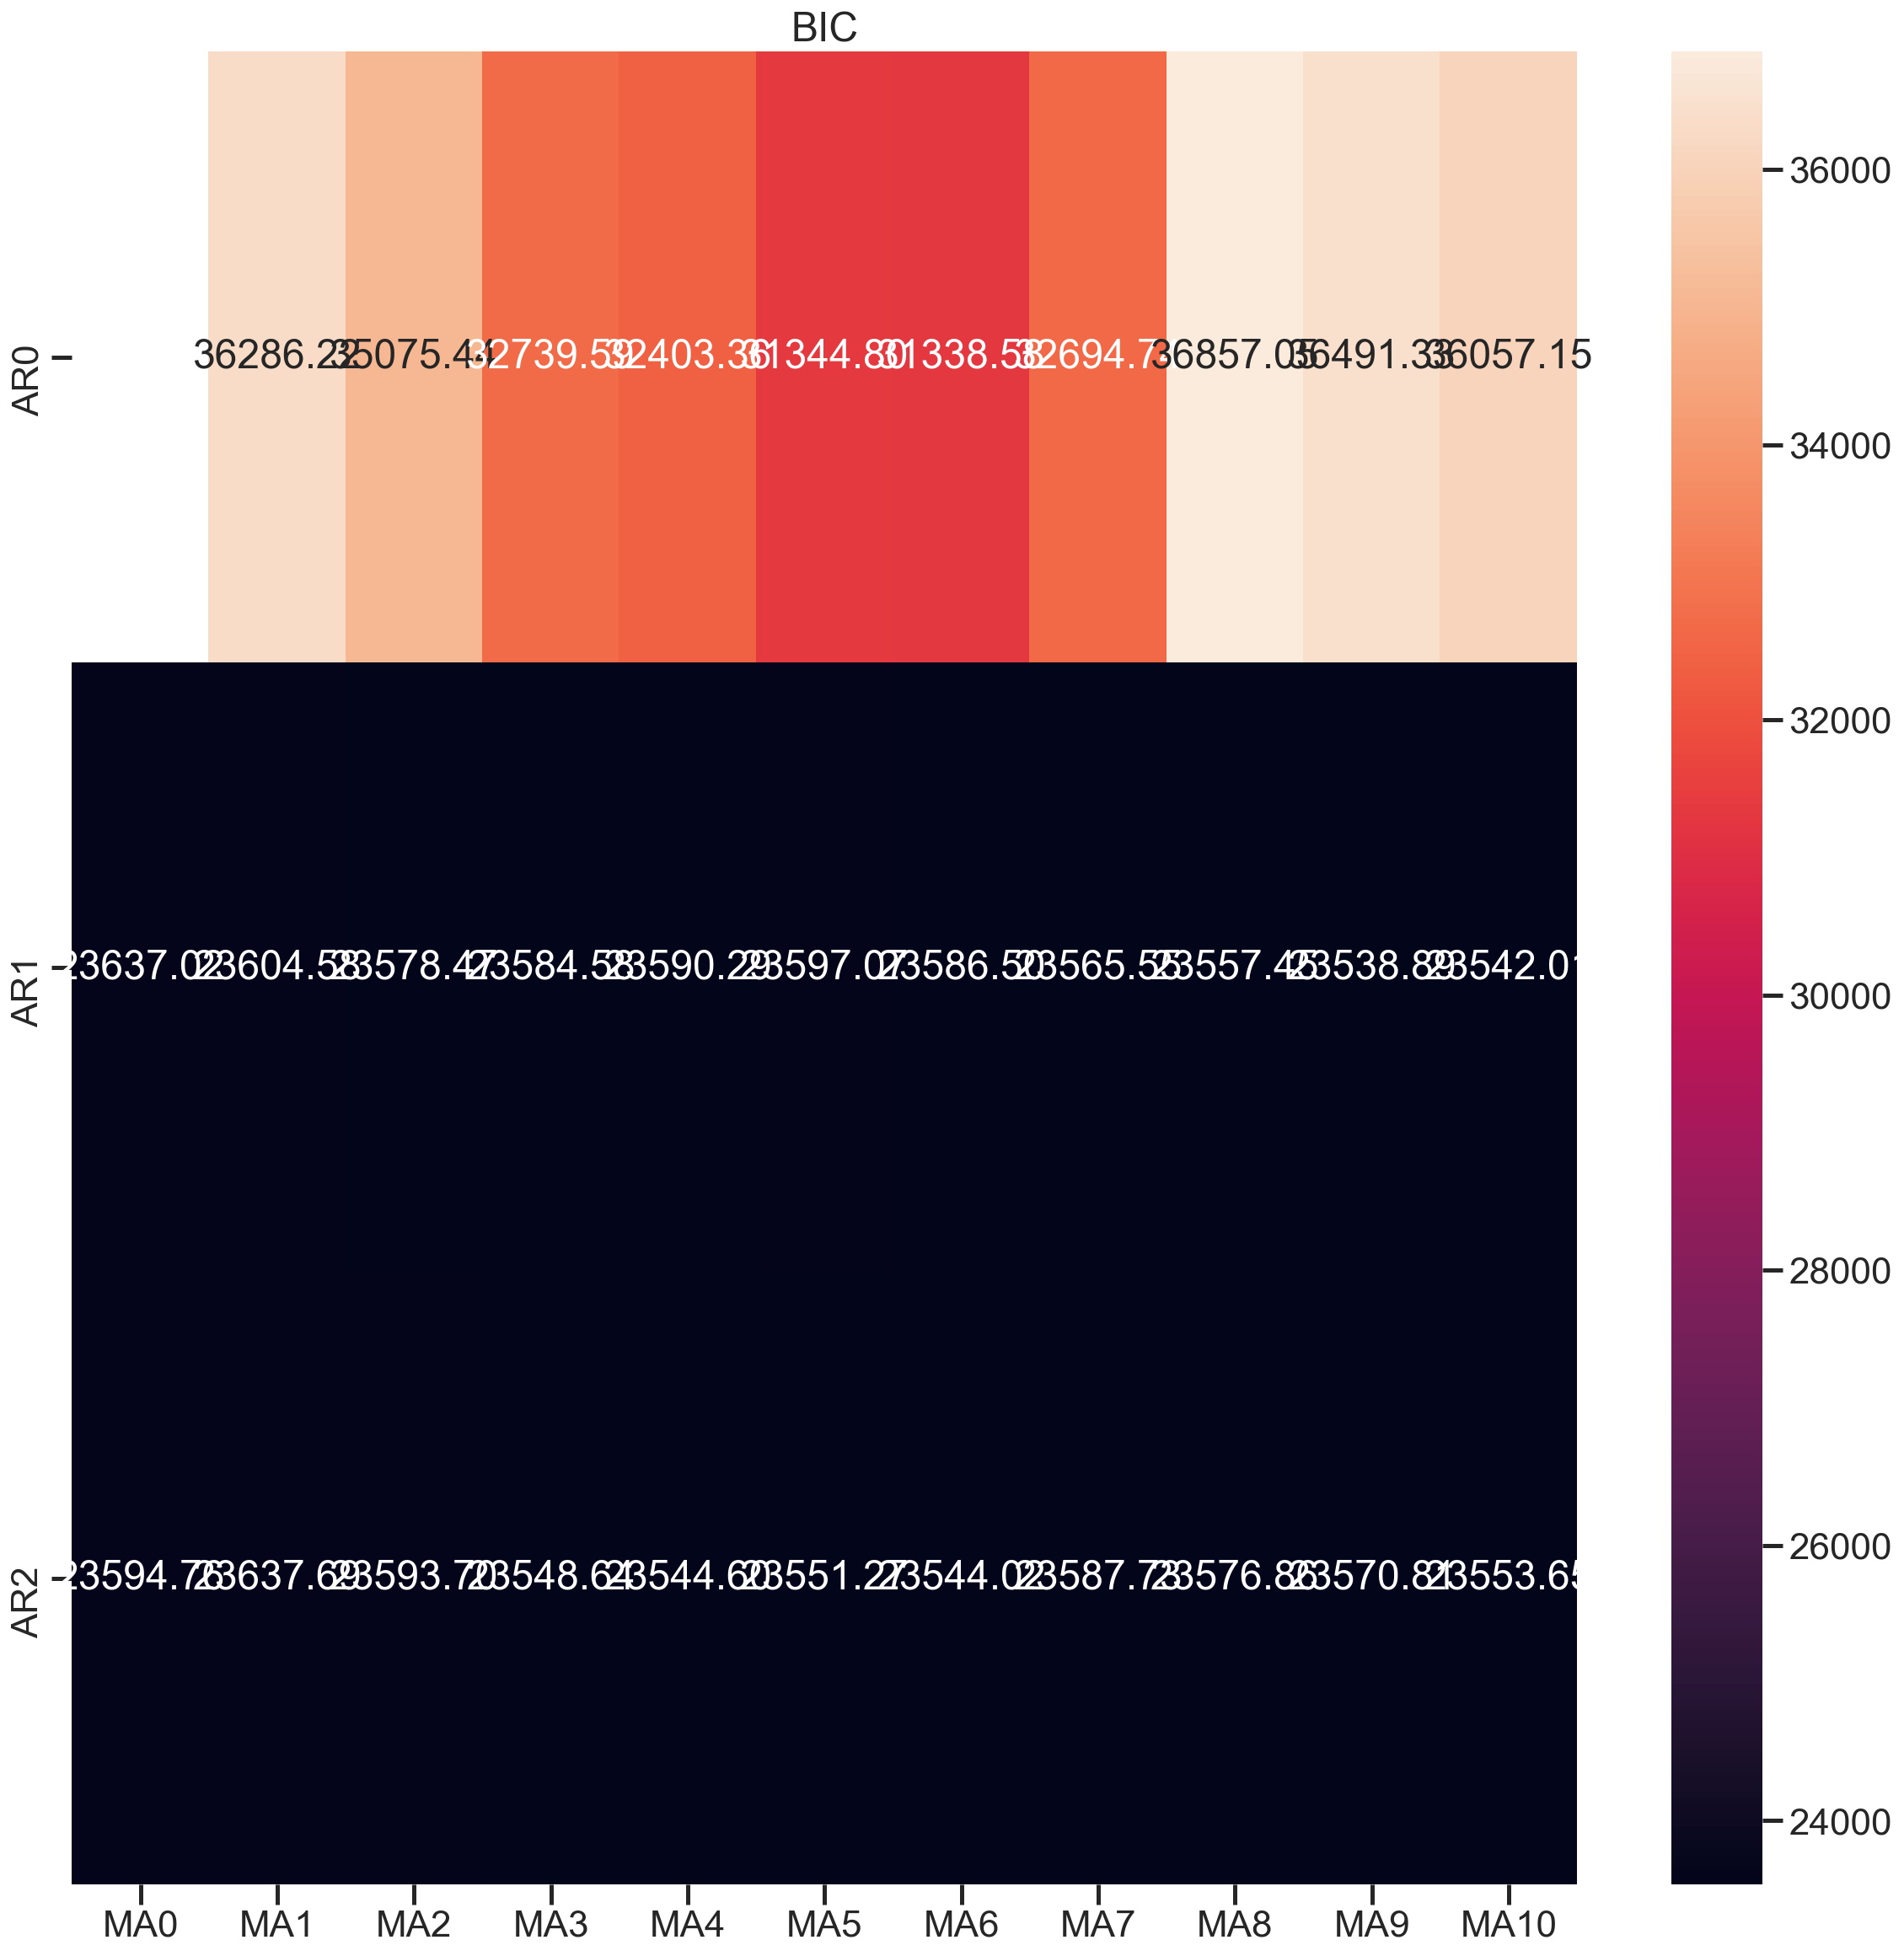

In [9]:
fig, ax = plt.subplots(figsize=(20, 20))
ax = sns.heatmap(results_bic,
                 mask=results_bic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 );
ax.set_title('BIC');

In [10]:
# Alternative model selection method, limited to only searching AR and MA parameters
 
train_results = sm.tsa.arma_order_select_ic(ts_train, ic=['aic', 'bic'], trend='nc', max_ar=2, max_ma=10)
print('AIC', train_results.aic_min_order)
print('BIC', train_results.bic_min_order)

D:\Anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\Anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated i

D:\Anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\Anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated i

D:\Anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\Anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum

AIC (2, 9)
BIC (1, 9)


D:\Anaconda\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
